## Preprocess the data

It's common to use some preprocessing of the data to make it easier for the algorithm to fit a model to it. Few common techniqes:

### Scaling numeric features

Normalizing numeric features so they're on the same scale prevents features with large values from producing coefficients that disproportionately affect the predictions. For example, suppose our data includes the following numeric features:

| A | B | C |
|---|---|---|
| 3 |480| 65|


Normalizing these features to the same scale may result in the following values (assuming A contains values from 0 to 10, B contains values from 0 to 1000, and C contains values from 0 to 100):

| A | B  | C  |
|---|----|----|
|0.3|0.48|0.65|

There are multiple ways we can scale numeric data, such as calculating the minimum and maximum values for each column and assigning a proportional value between 0 and 1, or by using the mean and standard deviation of a normally distributed variable to maintain the same spread of values on a different scale.


### Encoding categorical variables

Machine-learning models work best with numeric features rather than text values, so we generally need to convert categorical features into numeric representations. For example, suppose our data includes the following categorical feature:

| Size |
|------|
|  S   |
|  M   |
|  L   |

We can apply *ordinal encoding*, like this:

| Size |
|------|
|  0   |
|  1   |
|  2   |

Or, we can use *one-hot encoding* to create individual binary features for each possible category value. For example, we can translate the possible categories into binary columns like this:

| Size_S | Size_M | Size_L |
|--------|--------|--------|
|    1   |    0   |    0   |
|    0   |    1   |    0   |
|    0   |    0   |    1   |


To apply these preprocessing techniques, we'll make use of Scikit learn's feature named pipelines.
These pipelines allow us to define a set of preprocessing steps that end with an algorithm. This is useful, because when we want to use the model to predict values from new data, we need to apply the same transformations (based on the same statistical distributions and category encodings used with the training data).

In [12]:
# imports
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [13]:
# download the training data
!wget https://raw.githubusercontent.com/MicrosoftDocs/mslearn-introduction-to-machine-learning/main/Data/ml-basics/daily-bike-share.csv

--2024-03-29 21:15:17--  https://raw.githubusercontent.com/MicrosoftDocs/mslearn-introduction-to-machine-learning/main/Data/ml-basics/daily-bike-share.csv
Loaded CA certificate '/etc/ssl/certs/ca-certificates.crt'
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 2606:50c0:8000::154, 2606:50c0:8002::154, 2606:50c0:8003::154, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|2606:50c0:8000::154|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 48800 (48K) [text/plain]
Saving to: ‘daily-bike-share.csv.1’

daily-bike-share.cs 100%[===================>]  47.66K  --.-KB/s    in 0.03s   

2024-03-29 21:15:17 (1.38 MB/s) - ‘daily-bike-share.csv.1’ saved [48800/48800]



In [14]:
# load the data
bike_data = pd.read_csv("daily-bike-share.csv")
bike_data['day'] = pd.DatetimeIndex(bike_data['dteday']).day
numeric_features = ['temp', 'atemp', 'hum', 'windspeed']
categorical_features = ['season','mnth','holiday','weekday','workingday','weathersit', 'day']
print(bike_data.head())
bike_data[numeric_features + ['rentals']].describe()

   instant    dteday  season  yr  mnth  holiday  weekday  workingday  \
0        1  1/1/2011       1   0     1        0        6           0   
1        2  1/2/2011       1   0     1        0        0           0   
2        3  1/3/2011       1   0     1        0        1           1   
3        4  1/4/2011       1   0     1        0        2           1   
4        5  1/5/2011       1   0     1        0        3           1   

   weathersit      temp     atemp       hum  windspeed  rentals  day  
0           2  0.344167  0.363625  0.805833   0.160446      331    1  
1           2  0.363478  0.353739  0.696087   0.248539      131    2  
2           1  0.196364  0.189405  0.437273   0.248309      120    3  
3           1  0.200000  0.212122  0.590435   0.160296      108    4  
4           1  0.226957  0.229270  0.436957   0.186900       82    5  


,temp,atemp,hum,windspeed,rentals
count,731.000000,731.000000,731.000000,731.000000,731.000000
mean,0.495385,0.474354,0.627894,0.190486,848.176471
std,0.183051,0.162961,0.142429,0.077498,686.622488
min,0.059130,0.079070,0.000000,0.022392,2.000000
25%,0.337083,0.337842,0.520000,0.134950,315.500000
50%,0.498333,0.486733,0.626667,0.180975,713.000000
75%,0.655417,0.608602,0.730209,0.233214,1096.000000
max,0.861667,0.840896,0.972500,0.507463,3410.000000


In [15]:
# separate features and labels
X, y = bike_data[['season', 'mnth','holiday', 'weekday', 'workingday', 'weathersit', 'temp', 'atemp', 'hum', 'windspeed']].values, bike_data['rentals'].values

# separate data into training set and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=0)

print(f"Training set: {X_train.shape[0]}\nTest set: {X_test.shape[0]}")

Training set: 511
Test set: 220


In [16]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor


# define preprocessing for numeric columns
numeric_features = [6,7,8,9]
numeric_transformer = Pipeline(
    steps=[(
        'scaler', StandardScaler()
    )]
)

# define preprocessing for categorical features
categorical_features = [0,1,3,4,5]
categorical_transformer = Pipeline(
    steps=[(
        'onehot', OneHotEncoder(handle_unknown='ignore')
    )]
)


# combine preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)

# create preprocessing and training pipeline
pipeline = Pipeline(
    steps=[
        ('preprocessor', preprocessor),
        ('regressor', GradientBoostingRegressor())
    ]
)

model = pipeline.fit(X_train, (y_train))
print(model)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  [6, 7, 8, 9]),
                                                 ('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  [0, 1, 3, 4, 5])])),
                ('regressor', GradientBoostingRegressor())])


MSE: 104716.15638012902
RMSE: 323.5987583105489
R2: 0.7947105477841779


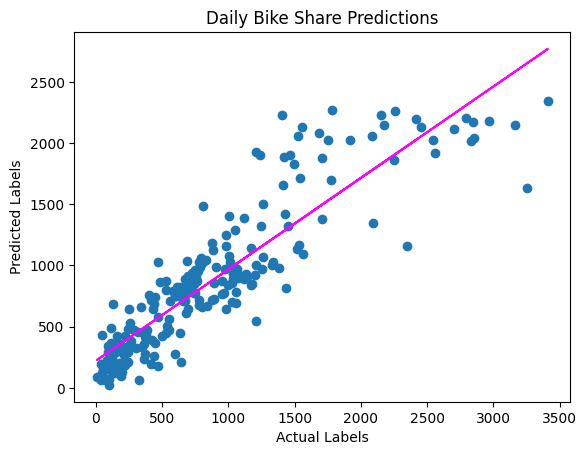

In [17]:
# evaluate the model
predictions = model.predict(X_test)

mse = mean_squared_error(y_test, predictions)
print("MSE:", mse)
rmse = np.sqrt(mse)
print("RMSE:", rmse)
r2 = r2_score(y_test, predictions)
print("R2:", r2)

# plot predicted vs actual
plt.scatter(y_test, predictions)
plt.xlabel('Actual Labels')
plt.ylabel('Predicted Labels')
plt.title('Daily Bike Share Predictions')
z = np.polyfit(y_test, predictions, 1)
p = np.poly1d(z)
plt.plot(y_test, p(y_test), color='magenta')
plt.show()

Try a different alogrithm

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  [6, 7, 8, 9]),
                                                 ('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  [0, 1, 3, 4, 5])])),
                ('regressor', RandomForestRegressor())]) 

MSE: 105366.68682363637
RMSE: 324.60235184551016
R2: 0.793435223679342


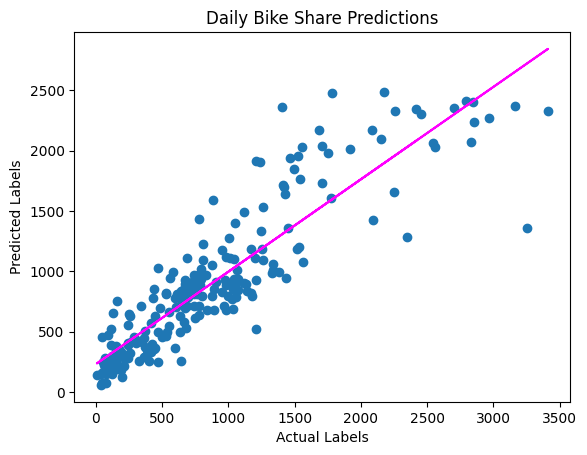

In [18]:
pipeline = Pipeline(
    steps=[
        ('preprocessor', preprocessor),
        ('regressor', RandomForestRegressor())
    ]
)

model = pipeline.fit(X_train, (y_train))
print(model, '\n')

# evaluate the model
predictions = model.predict(X_test)

mse = mean_squared_error(y_test, predictions)
print("MSE:", mse)
rmse = np.sqrt(mse)
print("RMSE:", rmse)
r2 = r2_score(y_test, predictions)
print("R2:", r2)

# plot predicted vs actual
plt.scatter(y_test, predictions)
plt.xlabel('Actual Labels')
plt.ylabel('Predicted Labels')
plt.title('Daily Bike Share Predictions')
z = np.polyfit(y_test, predictions, 1)
p = np.poly1d(z)
plt.plot(y_test, p(y_test), color='magenta')
plt.show()

In [19]:
import joblib

# Save the model as a pickle file
filename = './bike-share.pkl'
joblib.dump(model, filename)

['./bike-share.pkl']

In [20]:
loaded_model = joblib.load(filename)

# Create a numpy array containing a new observation (for example tomorrow's seasonal and weather forecast information)
X_new = np.array([[1,1,0,3,1,1,0.226957,0.22927,0.436957,0.1869]]).astype('float64')
print ('New sample: {}'.format(list(X_new[0])))

# Use the model to predict tomorrow's rentals
result = loaded_model.predict(X_new)
print('Prediction: {:.0f} rentals'.format(np.round(result[0])))

New sample: [1.0, 1.0, 0.0, 3.0, 1.0, 1.0, 0.226957, 0.22927, 0.436957, 0.1869]
Prediction: 97 rentals


In [21]:
# An array of features based on five-day weather forecast
X_new = np.array([[0,1,1,0,0,1,0.344167,0.363625,0.805833,0.160446],
                  [0,1,0,1,0,1,0.363478,0.353739,0.696087,0.248539],
                  [0,1,0,2,0,1,0.196364,0.189405,0.437273,0.248309],
                  [0,1,0,3,0,1,0.2,0.212122,0.590435,0.160296],
                  [0,1,0,4,0,1,0.226957,0.22927,0.436957,0.1869]])

# Use the model to predict rentals
results = loaded_model.predict(X_new)
print('5-day rental predictions:')
for prediction in results:
    print(np.round(prediction))

5-day rental predictions:
550.0
716.0
235.0
189.0
273.0
